# Filtering

In [41]:
import numpy as np
import scipy.io as sio
import scipy.signal as signal
from matplotlib import pyplot as plt
import copy

# Required for interactive plots in DataSpell
# import matplotlib
# matplotlib.use("nbagg")

### Load data

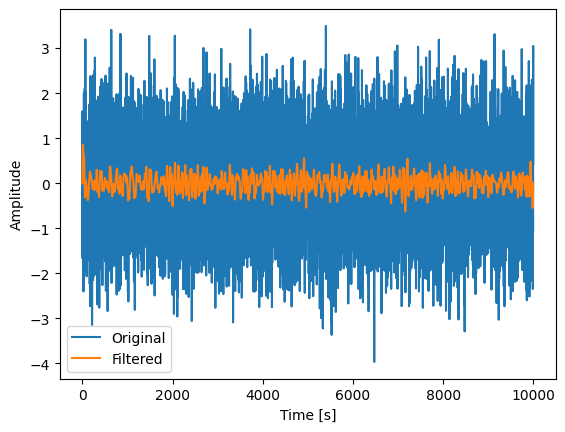

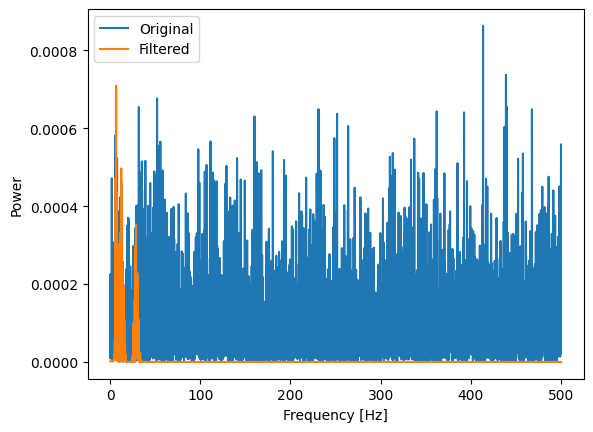

In [42]:
challengeData = sio.loadmat("Datasets/filtering_codeChallenge.mat")

# Extract data
fs = challengeData['fs'].flatten()[0]
originalSignal = challengeData['x'].flatten()
filteredSignal = challengeData['y'].flatten()
n = originalSignal.size

# Make plotting a fft easier
def plotFFT(data: np.ndarray, label: str = None):
    frequencies = np.fft.rfftfreq(data.size, 1/fs)
    power = np.abs(np.fft.rfft(data) / data.size)**2
    plt.plot(frequencies, power, label=label)

# Visualize results
plt.figure()
plt.plot(originalSignal, label='Original')
plt.plot(filteredSignal, label='Filtered')

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()

plt.figure()

plotFFT(originalSignal, label='Original')
plotFFT(filteredSignal, label='Filtered')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.legend()

plt.show()

### Zooming in
We can see two peaks in the filtered data, lets zoom in on them.

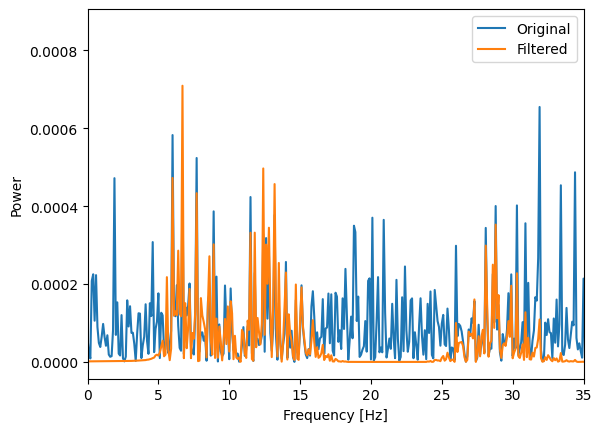

In [43]:
plt.figure()

plotFFT(originalSignal, label='Original')
plotFFT(filteredSignal, label='Filtered')

plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.xlim(0, 35)
plt.legend()

plt.show()

### Identifying frequency ranges
We can see two peaks, one from [5-15] Hz and one narrow peak from centered around 29 Hz.

We will reproduce this result by separating the data and applying the two bandpass filter separately. Then, we will add them together for the final result.

### First bandpass filter
Let's tackle the [5-15] Hz filter first.

We will start by creating the filter and checking its properties.

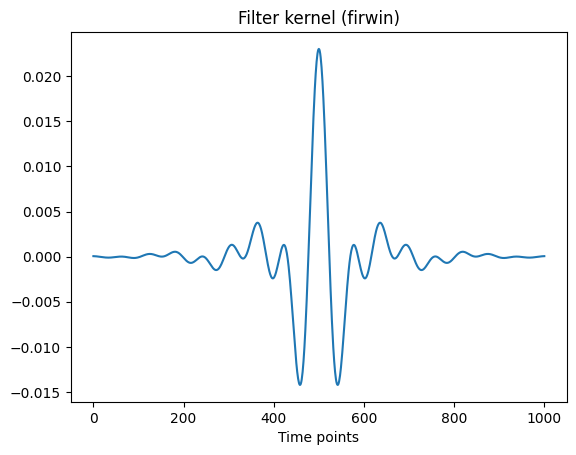

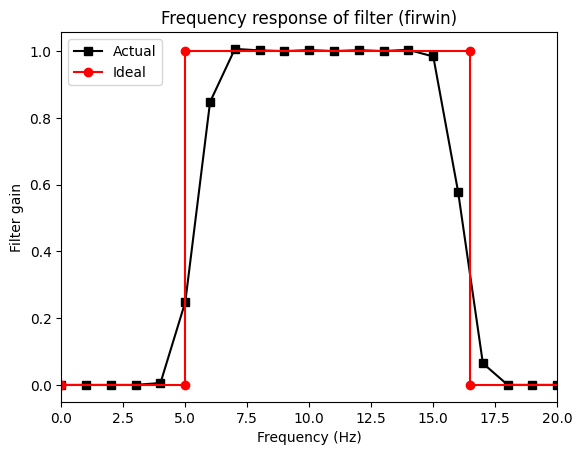

In [71]:
# filter parameters
nyquist = fs/2
frange  = [5, 16.5]
transw  = .1
order   = int(5 * fs/frange[0])

# force odd order
if order%2==0:
    order += 1

# filter kernel
filtkern = signal.firwin(order, frange, fs=fs, pass_zero=False)


# time-domain filter kernel
plt.plot(filtkern)
plt.xlabel('Time points')
plt.title('Filter kernel (firwin)')
plt.show()

# compute the power spectrum of the filter kernel
filtpow = np.abs(np.fft.fft(filtkern))**2

# compute the frequencies vector and remove negative frequencies
hz      = np.linspace(0, fs/2, int(np.floor(len(filtkern)/2)+1))
filtpow = filtpow[0:len(hz)]

# plot amplitude spectrum of the filter kernel
plt.plot(hz, filtpow, 'ks-', label='Actual')
plt.plot([0,frange[0],frange[0],frange[1],frange[1],nyquist],[0,0,1,1,0,0],'ro-',label='Ideal')
plt.xlim([0,frange[0]*4])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.legend()
plt.title('Frequency response of filter (firwin)')
plt.show()

### Applying the filter
Looks pretty good! The edges taper down a bit early, but we can see this happen in the reference signal as well.

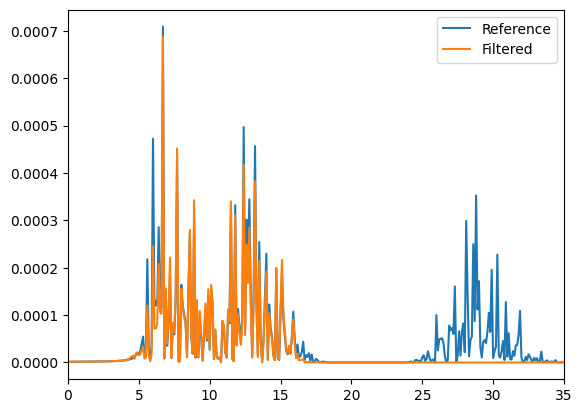

In [72]:
# zero-phase-shift filter
# firstFilteredData = signal.lfilter(filtkern, 1, originalSignal)                 # forward
# firstFilteredData = signal.lfilter(filtkern, 1, np.flip(firstFilteredData, 0))  # reverse
# firstFilteredData = np.flip(firstFilteredData, 0)                               # flip forward
firstFilteredData = signal.filtfilt(filtkern, 1, originalSignal)

plt.figure()
plotFFT(filteredSignal, label='Reference')
plotFFT(firstFilteredData, label='Filtered')
plt.legend()
plt.xlim(0, 35)

plt.show()

### Applying second filter
Hmm, not exactly correct, but fairly close. Let's tackle the second filter.

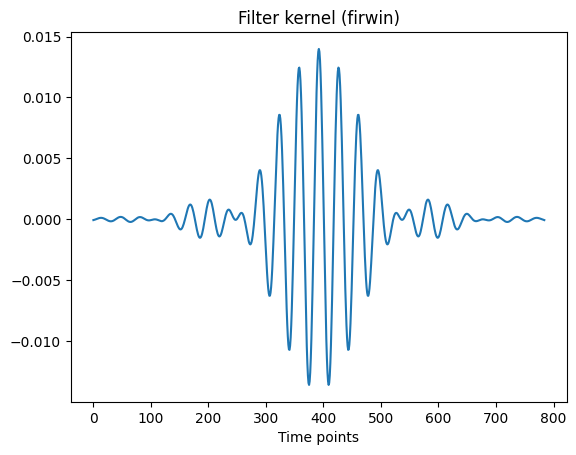

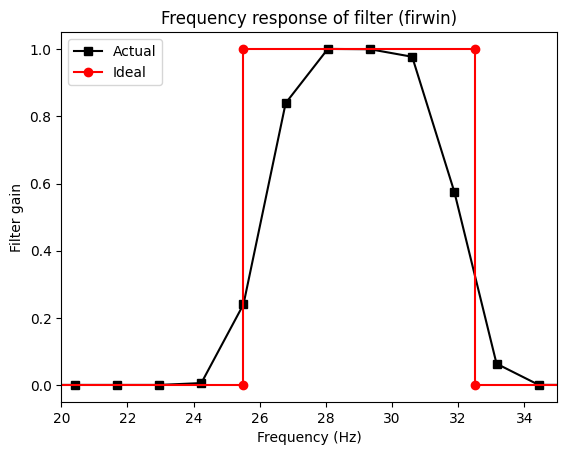

In [91]:
# filter parameters
nyquist = fs/2
frange  = [25.5, 32.5]
transw  = .1
order   = int(20 * fs/frange[0])

# force odd order
if order%2==0:
    order += 1

# filter kernel
filtkern = signal.firwin(order, frange, fs=fs, pass_zero=False)


# time-domain filter kernel
plt.plot(filtkern)
plt.xlabel('Time points')
plt.title('Filter kernel (firwin)')
plt.show()

# compute the power spectrum of the filter kernel
filtpow = np.abs(np.fft.fft(filtkern))**2

# compute the frequencies vector and remove negative frequencies
hz      = np.linspace(0, fs/2, int(np.floor(len(filtkern)/2)+1))
filtpow = filtpow[0:len(hz)]

# plot amplitude spectrum of the filter kernel
plt.plot(hz, filtpow, 'ks-', label='Actual')
plt.plot([0,frange[0],frange[0],frange[1],frange[1],nyquist],[0,0,1,1,0,0],'ro-',label='Ideal')
plt.xlim([20, 35])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Filter gain')
plt.legend()
plt.title('Frequency response of filter (firwin)')
plt.show()

Alright, the filter looks stable, but not quite sharp. However, these slow edges are also shown in the reference.

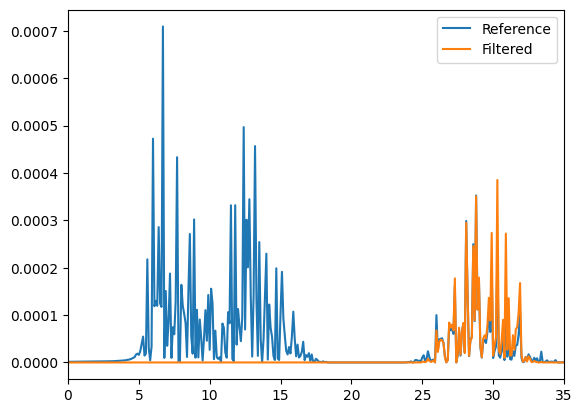

In [92]:
# zero-phase-shift filter
secondFilteredData = signal.filtfilt(filtkern, 1, originalSignal)

plt.figure()
plotFFT(filteredSignal, label='Reference')
plotFFT(secondFilteredData, label='Filtered')
plt.legend()
plt.xlim(0, 35)

plt.show()

### Combining the data
Nice! The second filter looks quite comparable! Now, add everything together

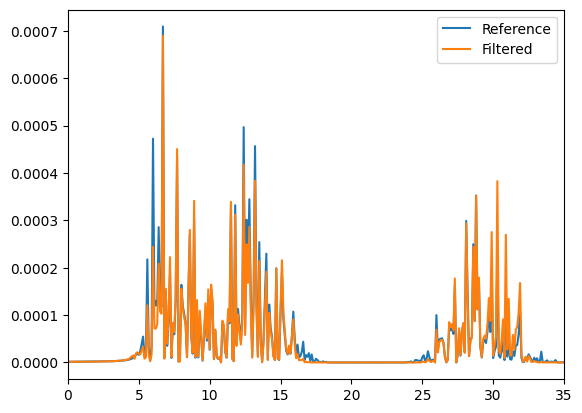

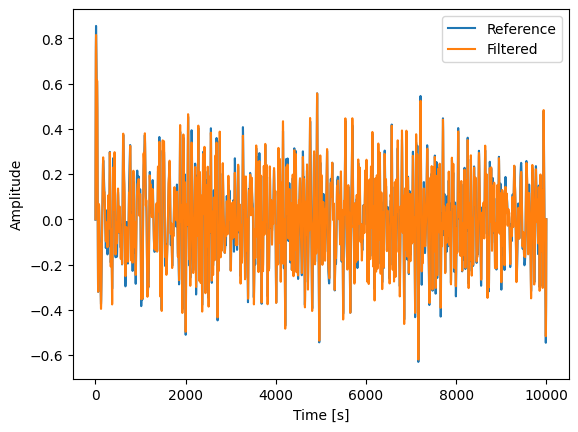

In [94]:
myFilteredSignal = firstFilteredData + secondFilteredData

plt.figure()
plotFFT(filteredSignal, label='Reference')
plotFFT(myFilteredSignal, label='Filtered')
plt.legend()
plt.xlim(0, 35)

plt.figure()
plt.plot(filteredSignal, label='Reference')
plt.plot(myFilteredSignal, label='Filtered')

plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.legend()

plt.show()

Now, that looks quite comparable!